In [175]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  # Importing pyplot directly
import warnings
import os

# Ignore SettingWithCopyWarning
warnings.filterwarnings('ignore')

# Define your API token and REDCap API URL
api_token = 'B594A04722FAF5BDA034E045994AD0D1'
api_url = 'https://redcap.oauife.edu.ng/api/'

# Define the parameters for exporting records
payload = {
    'token': api_token,
    'content': 'record',
    'format': 'json',
    'type': 'flat', 
    'rawOrLabel': 'raw',
    'rawOrLabelHeaders': 'raw',
    'exportDataAccessGroups': 'true'
}

# Make the request to the REDCap API
response = requests.post(api_url, data=payload)

# Make the request to the REDCap API
response = requests.post(api_url, data=payload)

# Check if the request was successful
if response.status_code == 200:
    # Convert the JSON response to a pandas DataFrame
    data = response.json()
    msi = pd.DataFrame(data)
    msi.replace('', pd.NA, inplace=True)
    msi['record_id'] = pd.to_numeric(msi['record_id'], errors='coerce')
    print("DataFrame created successfully.")
else:
    print("Error accessing REDCap API:", response.text)

DataFrame created successfully.


In [188]:
def check_slide_presence(slide_table, file_type='svs'):
    """
    Check for the presence of slide files listed in the clinical table.
    
    Parameters:
        slide_table (DataFrame): DataFrame containing patient IDs and file paths.
        file_type (str, optional): Type of files to check for. Can be 'svs', 'h5', or 'both'. Default is 'svs'.
    
    Returns:
        presence_dict (dict): Dictionary indicating presence of slide files for each patient ID.
    """
    presence_dict = {}
    missing_files = []

    for index, row in slide_table.iterrows():
        patient_id = row['patient_id']
        svs_filename = row['svs_filename']
        h5_filename = row['h5_filename']

        if file_type == 'svs':
            file_path = svs_filename
        elif file_type == 'h5':
            file_path = h5_filename
        elif file_type == 'both':
            file_path = svs_filename, h5_filename

        if isinstance(file_path, tuple):
            file_exists = all(os.path.exists(file) for file in file_path)
        else:
            file_exists = os.path.exists(file_path)

        if not file_exists:
            missing_files.append((patient_id, file_path))

        presence_dict[patient_id] = file_exists

    # Print missing files
    if missing_files:
        print("Missing files:")
        for patient_id, file_path in missing_files:
            print(f"Patient ID: {patient_id}, File: {file_path}")
    else:
        print("No missing files")

    return presence_dict

In [177]:
def analyze_retrospective(data_table, output_name, file_directory):
    """
    Clean up retrospective data
    
    Parameters:
        data_table (DataFrame): The DataFrame containing the data.
        output_name (str): The name or title for the histogram plot.
        file_directory (str): The path to directory where files are stored.
        
    Returns:
        slide_table (DataFrame): Slide table containing patient IDs, filenames, and associated information.
    """
    # Calculate the frequency of occurrences of each patient ID
    slide_counts = data_table['patient_id'].value_counts()
    
    # Create slide_table DataFrame
    slide_table = data_table[['patient_id', 'filename']].drop_duplicates()
    slide_table['svs_filename'] = file_directory + 'raw/' + slide_table['filename'] + '.svs'
    slide_table['h5_filename'] = file_directory + 'processed/STAMP_macenko_xiyuewang-ctranspath-7c998680/' + slide_table['filename'] + '.h5'
    
    # Save slide_table to CSV
    slide_table_output = slide_table[['patient_id', 'filename']]
    slide_table_output.rename(columns={'patient_id': 'PATIENT', 'filename': 'FILENAME'}, inplace=True)
    csv_filename = 'tables/' + output_name + '_slide_table' + '.csv'
    slide_table_output.to_csv(csv_filename, index=False)
    
    # Drop the 'filename' column
    clinical_table = data_table.drop(columns=['filename'])
    clinical_table = clinical_table.groupby('patient_id').first().reset_index()
    clinical_table['isMSIH'] = clinical_table['ismsih'].map({'1': 'MSI-H', '0': 'MSS'})
    clinical_table = clinical_table.merge(slide_counts.rename('slide_counts'), left_on='patient_id', right_index=True)
    clinical_table.sort_values(by='record_id', ascending=True, inplace=True)
    
    # Save slide_table to CSV
    clinical_table_output = clinical_table[['patient_id', 'isMSIH']]
    clinical_table_output.rename(columns={'patient_id': 'PATIENT'}, inplace=True)
    csv_filename = 'tables/' + output_name + '_clinical_table' + '.csv'
    clinical_table_output.to_csv(csv_filename, index=False)
    
    # Plot histograms of number of slides per patient and distribution of isMSIH
    sns.set_style('white')
    fig, axes = plt.subplots(1, 2, figsize=(8, 6))
    
    # Plot histogram of number of slides per patient
    sns.countplot(data=clinical_table, x='slide_counts', ax=axes[0])
    axes[0].set_title('Slides per Patient')
    axes[0].set_xlabel('Number of Slides per Patient')
    axes[0].set_ylabel('Frequency')
    for p in axes[0].patches:
        axes[0].annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 5), 
                         textcoords = 'offset points',
                         color='darkred')
        
    # Plot distribution of isMSIH
    sns.countplot(data=clinical_table, x='isMSIH', ax=axes[1])
    axes[1].set_title('Distribution of MSI Status')
    axes[1].set_xlabel('MSI Status')
    axes[1].set_ylabel('Frequency')
    for p in axes[1].patches:
        axes[1].annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 5), 
                         textcoords = 'offset points',
                         color='darkred')
        
    plt.tight_layout()
    plt.show()
    return slide_table, clinical_table

In [208]:
def analyze_impact(data_table):
    """
    Analyze the impact of MSI status and score.
    
    Parameters:
        data_table (DataFrame): DataFrame containing MSI status and score.
        
    Returns:
        filtered_data (DataFrame): DataFrame after filtering out rows with missing values for MSI score and status.
    """
    # Filter out rows with missing values for MSI score and status
    rows_before = len(data_table)
    filtered_data = data_table.dropna(subset=['cmo_msi_score', 'cmo_msi_status'])
    filtered_data['cmo_msi_score'] = pd.to_numeric(filtered_data['cmo_msi_score'], errors='coerce')
    rows_after = len(filtered_data)
    print(f"Number of rows before dropping NA values: {rows_before}")
    print(f"Number of rows after dropping NA values: {rows_after}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot histogram of number of slides per patient
    sns.countplot(data=filtered_data, x='cmo_msi_status', ax=axes[0])
    axes[0].set_title('Distribution of MSI Status')
    axes[0].set_xlabel('MSI Status')
    axes[0].set_ylabel('Frequency')
    for p in axes[0].patches:
        axes[0].annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 5), 
                         textcoords = 'offset points',
                         color='darkred')
        
    # Plot distribution of isMSIH
    sns.histplot(data=filtered_data, x='cmo_msi_score', bins=20, ax=axes[1])
    axes[1].set_title('Distribution of MSI Score')
    axes[1].set_xlabel('MSI Score')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
    
    return filtered_data

In [259]:
def analyze_impact(data_table):
    """
    Analyze the impact of MSI status and score.
    
    Parameters:
        data_table (DataFrame): DataFrame containing MSI status, score, and slide name.
        
    Returns:
        filtered_data (DataFrame): DataFrame after filtering out rows with missing values for MSI score, status, and slide name.
    """
    # Filter out rows with missing values for MSI score, status, and slide name
    filtered_data = data_table.dropna(subset=['cmo_msi_score', 'cmo_msi_status', 'slide_name'])
    
    # Convert 'cmo_msi_score' to numeric, coercing errors
    filtered_data['cmo_msi_score'] = pd.to_numeric(filtered_data['cmo_msi_score'], errors='coerce')
    
    # Display number of rows before and after dropping NA values
    rows_before = len(data_table)
    rows_after = len(filtered_data)
    print(f"Number of rows before dropping NA values: {rows_before}")
    print(f"Number of rows after dropping NA values: {rows_after}")

    # Plot histograms
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot histogram of MSI status distribution
    sns.countplot(data=filtered_data, x='cmo_msi_status', ax=axes[0])
    axes[0].set_title('Distribution of MSI Status')
    axes[0].set_xlabel('MSI Status')
    axes[0].set_ylabel('Frequency')
    for p in axes[0].patches:
        axes[0].annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 5), 
                         textcoords = 'offset points',
                         color='darkred')
        
    # Plot histogram of MSI score distribution
    sns.histplot(data=filtered_data, x='cmo_msi_score', bins=20, ax=axes[1])
    axes[1].set_title('Distribution of MSI Score')
    axes[1].set_xlabel('MSI Score')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
    
    # Write Excel sheets for missing values in 'cmo_msi_score', 'cmo_msi_status', and 'slide_name'
    missing_impact = data_table[data_table['cmo_msi_status'].isna()]
    missing_slide = data_table[data_table['slide_name'].isna()]
    missing_slide_with_status = data_table[data_table['slide_name'].isna() & data_table['cmo_msi_status'].notna()]

    
    with pd.ExcelWriter('prospective_missing_data.xlsx') as writer:
        missing_impact.to_excel(writer, sheet_name='Missing IMPACT', index=False)
        missing_slide.to_excel(writer, sheet_name='Missing slide', index=False)
        missing_slide_with_status.to_excel(writer, sheet_name='Missing slide, IMPACT done', index=False)

    return filtered_data

def analyze_prospective(data_table, output_name, file_directory):

    """
    Clean up prospective data
    
    Parameters:
        data_table (DataFrame): The DataFrame containing the data.
        output_name (str): The name or title for the histogram plot.
        file_directory (str): The path to directory where files are stored.
        
    Returns:
        slide_table (DataFrame): Slide table containing patient IDs, filenames, and associated information.
    """    
    # Create slide_table DataFrame
    slide_table = data_table[['patient_id', 'slide_name', 'r01_redcap_data_access_group']].copy()
    slide_table['slide_name'] = slide_table['slide_name'].str.split(', ')
    slide_table = slide_table.explode('slide_name')
    slide_table['slide_name'] = slide_table['slide_name'].str.rstrip('.svs')
    
    slide_counts = slide_table['patient_id'].value_counts()

    # Assuming you still want to concatenate 'raw/' and '.svs' to each slide_name
    slide_table['svs_filename'] = file_directory + slide_table['r01_redcap_data_access_group'].str.upper() + '/raw/' + slide_table['slide_name'] + '.svs'
    slide_table['h5_filename'] = file_directory + slide_table['r01_redcap_data_access_group'].str.upper() + '/processed/STAMP_macenko_xiyuewang-ctranspath-7c998680/' + slide_table['slide_name'] + '.h5'
    
    slide_table_output = slide_table[['patient_id', 'slide_name', 'r01_redcap_data_access_group']]
    slide_table_output.rename(columns={'patient_id': 'PATIENT', 'slide_name': 'FILENAME', 'r01_redcap_data_access_group' : 'site'}, inplace=True)
    csv_filename = 'tables/' + output_name + '_slide_table' + '.csv'
    slide_table_output.to_csv(csv_filename, index=False)
        
    # Drop the 'filename' column
    clinical_table = data_table.drop(columns=['slide_name'])
    clinical_table['isMSIH'] = clinical_table['cmo_msi_status'].map({'Instable': 'MSI-H', 'Stable': 'MSS', 'Indeterminate': 'MSS', 'Stable, Indeterminate': 'MSS'})
    clinical_table = clinical_table.merge(slide_counts.rename('slide_counts'), left_on='patient_id', right_index=True)
    clinical_table.sort_values(by='record_id', ascending=True, inplace=True)
    
    # Save slide_table to CSV
    clinical_table_output = clinical_table[['patient_id', 'isMSIH', 'r01_redcap_data_access_group']]
    clinical_table_output.rename(columns={'patient_id': 'PATIENT', 'r01_redcap_data_access_group' : 'site'}, inplace=True)
    csv_filename = 'tables/' + output_name + '_clinical_table' + '.csv'
    clinical_table_output.to_csv(csv_filename, index=False)
    
    # Plot histograms of number of slides per patient and distribution of isMSIH
    sns.set_style('white')
    fig, axes = plt.subplots(1, 2, figsize=(8, 6))
    
    # Plot histogram of number of slides per patient
    sns.countplot(data=clinical_table, x='slide_counts', ax=axes[0])
    axes[0].set_title('Slides per Patient')
    axes[0].set_xlabel('Number of Slides per Patient')
    axes[0].set_ylabel('Frequency')
    for p in axes[0].patches:
        axes[0].annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 5), 
                         textcoords = 'offset points',
                         color='darkred')
        
    # Plot distribution of isMSIH
    sns.countplot(data=clinical_table, x='isMSIH', ax=axes[1])
    axes[1].set_title('Distribution of MSI Status')
    axes[1].set_xlabel('MSI Status')
    axes[1].set_ylabel('Frequency')
    for p in axes[1].patches:
        axes[1].annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 5), 
                         textcoords = 'offset points',
                         color='darkred')
        
    plt.tight_layout()
    plt.show()
    return slide_table, clinical_table

## Retrospective

In [248]:
proforma_complete_index = list(msi.columns).index('proforma_complete')
retrospective = msi.iloc[:, :proforma_complete_index]
retrospective = retrospective[(retrospective['batch_number'] == '1') | (retrospective['batch_number'] == '2')]
retrospective = retrospective.dropna(axis=1, how='all')
retrospective['patient_id'] = 'crc_' + retrospective['crc_redcap_number']
cols = retrospective.columns.tolist()
cols = ['patient_id'] + [col for col in cols if col != 'patient_id']
retrospective = retrospective[cols]
retrospective_msk = retrospective[(retrospective['batch_number'] == '1')]
retrospective_oau = retrospective[(retrospective['batch_number'] == '2')]

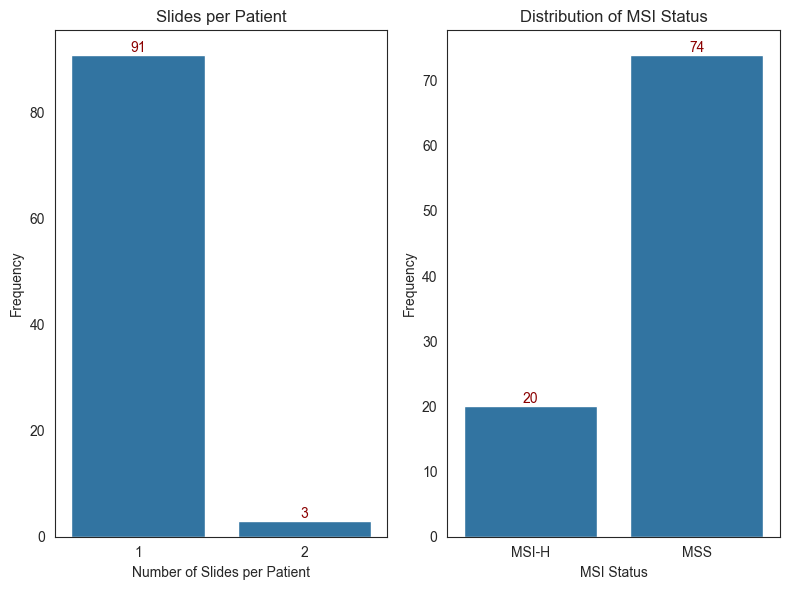

In [249]:
output_table_names = "retrospective_msk"
file_directory = "/lab/barcheese01/mdiberna/msi/retrospective_msk/"
retrospective_msk_slide_table, retrospective_msk_clinical_table = analyze_retrospective(retrospective_msk, output_table_names, file_directory)

In [250]:
retrospective_msk_svs = check_slide_presence(retrospective_msk_slide_table, file_type='svs')
retrospective_msk_dict_h5 = check_slide_presence(retrospective_msk_slide_table, file_type='h5')
retrospective_msk_slide_table

No missing files
No missing files


,patient_id,filename,svs_filename,h5_filename
0,crc_45,T45_1-1,/lab/barcheese01/mdiberna/msi/retrospective_ms...,/lab/barcheese01/mdiberna/msi/retrospective_ms...
1,crc_148,T148_1-1,/lab/barcheese01/mdiberna/msi/retrospective_ms...,/lab/barcheese01/mdiberna/msi/retrospective_ms...
2,crc_167,T167_1-1,/lab/barcheese01/mdiberna/msi/retrospective_ms...,/lab/barcheese01/mdiberna/msi/retrospective_ms...
3,crc_170,T170_1-1,/lab/barcheese01/mdiberna/msi/retrospective_ms...,/lab/barcheese01/mdiberna/msi/retrospective_ms...
4,crc_182,T182_1-1,/lab/barcheese01/mdiberna/msi/retrospective_ms...,/lab/barcheese01/mdiberna/msi/retrospective_ms...
...,...,...,...,...
92,crc_328,T328_1-1,/lab/barcheese01/mdiberna/msi/retrospective_ms...,/lab/barcheese01/mdiberna/msi/retrospective_ms...
93,crc_329,T329_1-1,/lab/barcheese01/mdiberna/msi/retrospective_ms...,/lab/barcheese01/mdiberna/msi/retrospective_ms...
94,crc_331,T331_1-1,/lab/barcheese01/mdiberna/msi/retrospective_ms...,/lab/barcheese01/mdiberna/msi/retrospective_ms...
95,crc_332,T332_1-1,/lab/barcheese01/mdiberna/msi/retrospective_ms...,/lab/barcheese01/mdiberna/msi/retrospective_ms...


In [251]:
retrospective_msk_clinical_table

,patient_id,record_id,study_site,hospital_number,crc_redcap_number,histology_number,histology_number2,date_of_recruitment,date_of_surgery,msi_method,...,batch_number,sample_type,tissue_processing_site,slide_staining_site,tumor_present,scanned,patient,ismsih,isMSIH,slide_counts
93,crc_45,1,OAU,uith-567817,45,H579/14 (UITH),None,2014-04-19,2014-04-17,1,...,1,1,1,1,1,1,MSK_MSK45,1,MSI-H,1
0,crc_148,2,OAU,365052,148,H1218/15,None,2015-08-10,2016-05-31,1,...,1,1,1,1,1,1,MSK_MSK148,1,MSI-H,1
1,crc_167,3,OAU,None,167,H118/16,"H307/16 , H823/16",None,2015-12-19,1,...,1,1,1,1,1,1,MSK_MSK167,0,MSS,1
2,crc_170,4,OAU,265108,170,H58/16,None,2016-01-11,2016-05-16,1,...,1,1,1,1,1,1,MSK_MSK170,0,MSS,1
3,crc_182,5,OAU,375932,182,None,None,2016-05-25,2016-05-25,1,...,1,1,1,1,1,1,MSK_MSK182,0,MSS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,crc_328,93,OAU,None,328,H2214/17,H2318/17,2017-11-30,2017-12-18,1,...,1,1,1,1,1,1,MSK_MSK328,1,MSI-H,1
89,crc_329,94,OAU,397314,329,None,None,2017-11-21,2017-11-20,1,...,1,1,1,1,1,1,MSK_MSK329,0,MSS,1
90,crc_331,95,OAU,S-13801,331,None,None,2017-11-30,2017-11-28,1,...,1,1,1,1,1,1,MSK_MSK331,0,MSS,1
91,crc_332,96,OAU,398029,332,H2238/17,None,None,2017-12-07,1,...,1,1,1,1,1,1,MSK_MSK332,0,MSS,1


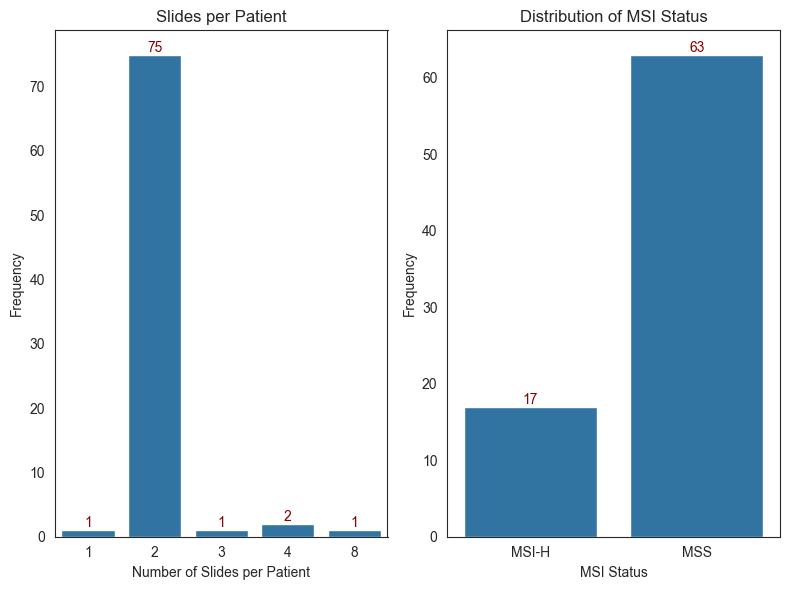

In [252]:
output_table_names = "retrospective_oau"
file_directory = "/lab/barcheese01/mdiberna/msi/retrospective_oau/"
retrospective_oau_slide_table, retrospective_oau_clinical_table = analyze_retrospective(retrospective_oau, output_table_names, file_directory)

In [253]:
retrospective_oau_dict_svs = check_slide_presence(retrospective_oau_slide_table, file_type='svs')
retrospective_oau_dict_h5 = check_slide_presence(retrospective_oau_slide_table, file_type='h5')
retrospective_oau_slide_table

No missing files
No missing files


,patient_id,filename,svs_filename,h5_filename
97,crc_45,T45-1-1-USS,/lab/barcheese01/mdiberna/msi/retrospective_oa...,/lab/barcheese01/mdiberna/msi/retrospective_oa...
98,crc_45,T45-1-1-USS-2,/lab/barcheese01/mdiberna/msi/retrospective_oa...,/lab/barcheese01/mdiberna/msi/retrospective_oa...
99,crc_148,T148-1-1-USS,/lab/barcheese01/mdiberna/msi/retrospective_oa...,/lab/barcheese01/mdiberna/msi/retrospective_oa...
100,crc_148,T148-1-1-USS-2,/lab/barcheese01/mdiberna/msi/retrospective_oa...,/lab/barcheese01/mdiberna/msi/retrospective_oa...
101,crc_167,T167-1-1-USS,/lab/barcheese01/mdiberna/msi/retrospective_oa...,/lab/barcheese01/mdiberna/msi/retrospective_oa...
...,...,...,...,...
262,crc_329,T329-1-1-4,/lab/barcheese01/mdiberna/msi/retrospective_oa...,/lab/barcheese01/mdiberna/msi/retrospective_oa...
263,crc_331,T331-1-1-4,/lab/barcheese01/mdiberna/msi/retrospective_oa...,/lab/barcheese01/mdiberna/msi/retrospective_oa...
264,crc_331,T331-1-3,/lab/barcheese01/mdiberna/msi/retrospective_oa...,/lab/barcheese01/mdiberna/msi/retrospective_oa...
265,crc_332,T332-1-1-3,/lab/barcheese01/mdiberna/msi/retrospective_oa...,/lab/barcheese01/mdiberna/msi/retrospective_oa...


In [254]:
retrospective_oau_clinical_table

,patient_id,record_id,study_site,hospital_number,crc_redcap_number,histology_number,histology_number2,date_of_recruitment,date_of_surgery,msi_method,...,batch_number,sample_type,tissue_processing_site,slide_staining_site,tumor_present,scanned,patient,ismsih,isMSIH,slide_counts
79,crc_45,98,OAU,uith-567817,45,H579/14 (UITH),None,2014-04-19,2014-04-17,1,...,2,1,1,1,1,1,MSK_OAU45,1,MSI-H,2
0,crc_148,100,OAU,365052,148,H1218/15,None,2015-08-10,2016-05-31,1,...,2,1,1,1,1,1,MSK_OAU148,1,MSI-H,2
1,crc_167,102,OAU,None,167,H118/16,"H307/16 , H823/16",None,2015-12-19,1,...,2,1,1,1,1,1,MSK_OAU167,0,MSS,2
2,crc_170,104,OAU,265108,170,H58/16,None,2016-01-11,2016-05-16,1,...,2,1,1,1,1,1,MSK_OAU170,0,MSS,2
3,crc_182,106,OAU,375932,182,None,None,2016-05-25,2016-05-25,1,...,2,1,1,1,1,1,MSK_OAU182,0,MSS,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,crc_327,258,OAU,261860,327,H2242/17,None,2017-11-30,None,1,...,2,2,1,1,1,1,MSK_OAU327,0,MSS,2
75,crc_328,260,OAU,None,328,H2214/17,H2318/17,2017-11-30,2017-12-18,1,...,2,1,1,1,1,1,MSK_OAU328,1,MSI-H,2
76,crc_329,262,OAU,397314,329,None,None,2017-11-21,2017-11-20,1,...,2,1,1,1,1,1,MSK_OAU329,0,MSS,2
77,crc_331,264,OAU,S-13801,331,None,None,2017-11-30,2017-11-28,1,...,2,1,1,1,1,1,MSK_OAU331,0,MSS,2


## Prospective

In [260]:
prospective = msi.iloc[:, proforma_complete_index + 1:]
prospective = pd.concat([msi['record_id'], msi['batch_number'], prospective], axis=1)
prospective = prospective[(prospective['batch_number'] != '1') & (prospective['batch_number'] != '2')]
prospective = prospective.dropna(axis=1, how='all')
prospective.rename(columns={'patient_id': 'msk_patient_id', 'sample_id': 'msk_sample_id'}, inplace=True)
prospective['patient_id'] = prospective['r01_redcap_data_access_group'] + '_' + prospective['r01_record_id']
cols = prospective.columns.tolist()
cols = ['patient_id'] + [col for col in cols if col != 'patient_id']
prospective = prospective[cols]
prospective

,patient_id,record_id,batch_number,r01_record_id,r01_redcap_data_access_group,r01_colorectal_record_id,r01_patient_firstname,r01_patient_name,r01_cohort,r01_hospital_number,...,r01_date_shipment_msk_tissue_r01,crc_surgery_date,r01_label_sample_tissue_r01,slide_name,slide_retrieved,msk_patient_id,msk_sample_id,cmo_msi_score,cmo_msi_status,imported_data_complete
267,oauthc_478-2,268,3,478-2,oauthc,46-560,BABATUNDE,IYIOLA,1,255173,...,2021-07-12,2021-04-19,T1IB77M,"H655-21-4.svs, H665-21-1.svs, H665-21-2.svs, H...",Yes,<NA>,<NA>,<NA>,<NA>,0
268,oauthc_478-1,269,3,478-1,oauthc,46-559,abiodun,fajojuto,1,278736,...,2021-07-12,2021-10-26,T2FA40M,<NA>,Missing?,C-F2NTDX,s_C_F2NTDX_T001_d,1.76,Stable,0
269,oauthc_478-3,270,3,478-3,oauthc,46-563,Olalekan,Abiola,1,432195,...,2021-07-12,2020-11-26,T3AO24M,<NA>,No number,<NA>,<NA>,<NA>,<NA>,0
270,oauthc_478-4,271,3,478-4,oauthc,46-562,Kayode,Akinbode,1,433781,...,2021-07-12,2021-04-26,T4AK64M,"H692-21-48.svs, H692-21-EX1.svs, H692-21-EX2.s...",Yes,<NA>,<NA>,<NA>,<NA>,0
271,oauthc_478-5,272,3,478-5,oauthc,46-564,Oluwole,Babajide,1,313441,...,2021-07-12,2022-06-06,T5BO89M,<NA>,Missing?,C-6MTWF9,s_C_6MTWF9_T001_d,5.84,Indeterminate,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,uith_481-281,543,<NA>,481-281,uith,<NA>,Racheal,Sanni,<NA>,792563,...,<NA>,<NA>,<NA>,TH554-23-2.svs,Yes,<NA>,<NA>,<NA>,<NA>,0
541,uith_481-283,544,<NA>,481-283,uith,<NA>,Peter,Oshin,<NA>,1540/1/2023,...,<NA>,<NA>,<NA>,TH675-23-1.svs,Yes,<NA>,<NA>,<NA>,<NA>,0
542,uith_481-284,545,<NA>,481-284,uith,<NA>,Fatai,Nuhu,<NA>,16967,...,<NA>,<NA>,<NA>,TH678-23.svs,Yes,<NA>,<NA>,<NA>,<NA>,0
543,oauthc_478-421,546,<NA>,478-421,oauthc,46-703,MOJISOLA,BAYODE,1,OWO-192309,...,2023-04-03,2023-01-11,<NA>,<NA>,No number,<NA>,<NA>,<NA>,<NA>,0


Number of rows before dropping NA values: 278
Number of rows after dropping NA values: 80


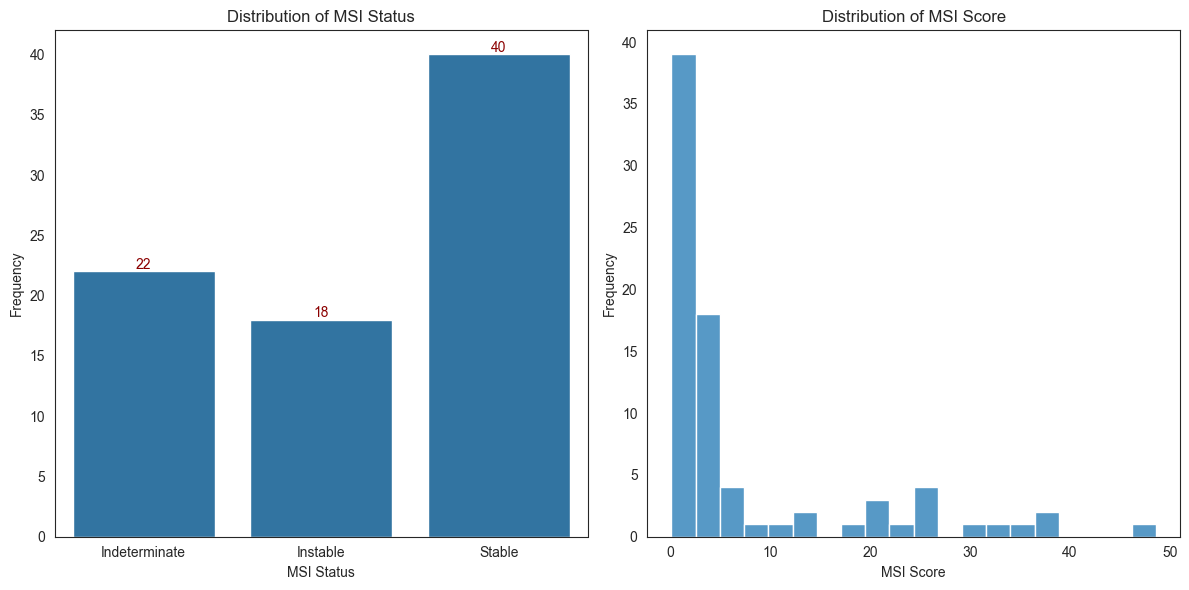

In [261]:
prospective_filtered = analyze_impact(prospective)

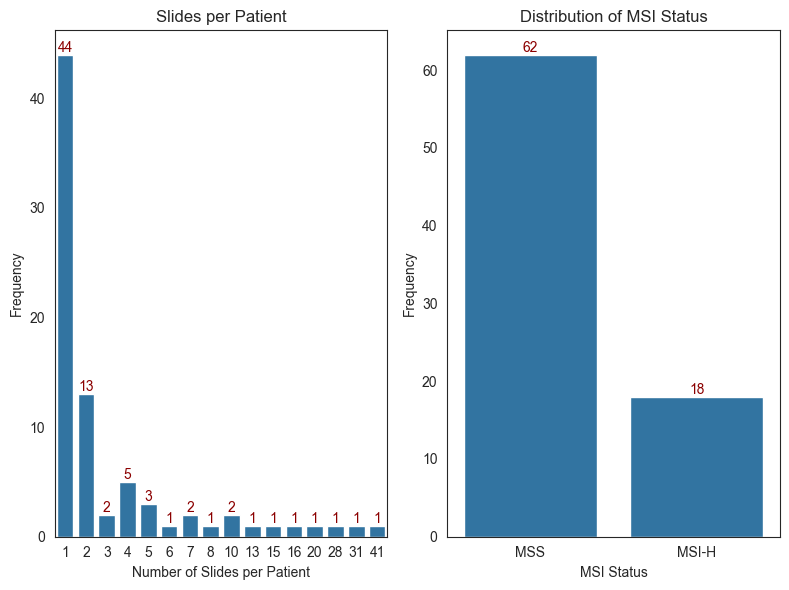

In [262]:
output_table_names = "prospective"
file_directory = "/lab/barcheese01/mdiberna/msi/"
prospective_slide_table, prospective_clinical_table = analyze_prospective(prospective_filtered, output_table_names, file_directory)

In [265]:
prospective_dict_svs = check_slide_presence(prospective_slide_table, file_type='svs')
prospective_dict_h5 = check_slide_presence(prospective_slide_table, file_type='h5')
prospective_slide_table

No missing files
Missing files:
Patient ID: oauthc_478-360, File: /lab/barcheese01/mdiberna/msi/OAUTHC/processed/STAMP_macenko_xiyuewang-ctranspath-7c998680/H1487-22-A2.h5
Patient ID: oauthc_478-360, File: /lab/barcheese01/mdiberna/msi/OAUTHC/processed/STAMP_macenko_xiyuewang-ctranspath-7c998680/H1487-22-A5.h5
Patient ID: oauthc_478-360, File: /lab/barcheese01/mdiberna/msi/OAUTHC/processed/STAMP_macenko_xiyuewang-ctranspath-7c998680/H1487-22-A9.h5
Patient ID: oauthc_478-364, File: /lab/barcheese01/mdiberna/msi/OAUTHC/processed/STAMP_macenko_xiyuewang-ctranspath-7c998680/H1560-22-6-1.h5
Patient ID: oauthc_478-364, File: /lab/barcheese01/mdiberna/msi/OAUTHC/processed/STAMP_macenko_xiyuewang-ctranspath-7c998680/H1560-22-6.h5
Patient ID: oauthc_478-364, File: /lab/barcheese01/mdiberna/msi/OAUTHC/processed/STAMP_macenko_xiyuewang-ctranspath-7c998680/H1560-22-9.h5
Patient ID: oauthc_478-370, File: /lab/barcheese01/mdiberna/msi/OAUTHC/processed/STAMP_macenko_xiyuewang-ctranspath-7c998680/H153

,patient_id,slide_name,r01_redcap_data_access_group,svs_filename,h5_filename
272,oauthc_478-6,H1689-20-B,oauthc,/lab/barcheese01/mdiberna/msi/OAUTHC/raw/H1689...,/lab/barcheese01/mdiberna/msi/OAUTHC/processed...
272,oauthc_478-6,H88-21-A1,oauthc,/lab/barcheese01/mdiberna/msi/OAUTHC/raw/H88-2...,/lab/barcheese01/mdiberna/msi/OAUTHC/processed...
272,oauthc_478-6,H88-21-A2,oauthc,/lab/barcheese01/mdiberna/msi/OAUTHC/raw/H88-2...,/lab/barcheese01/mdiberna/msi/OAUTHC/processed...
272,oauthc_478-6,H1689-20-B,oauthc,/lab/barcheese01/mdiberna/msi/OAUTHC/raw/H1689...,/lab/barcheese01/mdiberna/msi/OAUTHC/processed...
275,oauthc_478-9,H79-21-A-1,oauthc,/lab/barcheese01/mdiberna/msi/OAUTHC/raw/H79-2...,/lab/barcheese01/mdiberna/msi/OAUTHC/processed...
...,...,...,...,...,...
451,lasuth_510-62,B22_3700_MSI,lasuth,/lab/barcheese01/mdiberna/msi/LASUTH/raw/B22_3...,/lab/barcheese01/mdiberna/msi/LASUTH/processed...
453,lasuth_510-70,b22_1101_msi,lasuth,/lab/barcheese01/mdiberna/msi/LASUTH/raw/b22_1...,/lab/barcheese01/mdiberna/msi/LASUTH/processed...
455,lasuth_510-77,b22_1285_22,lasuth,/lab/barcheese01/mdiberna/msi/LASUTH/raw/b22_1...,/lab/barcheese01/mdiberna/msi/LASUTH/processed...
460,lasuth_510-107,HP1458_22,lasuth,/lab/barcheese01/mdiberna/msi/LASUTH/raw/HP145...,/lab/barcheese01/mdiberna/msi/LASUTH/processed...


In [264]:
prospective_clinical_table

,patient_id,record_id,batch_number,r01_record_id,r01_redcap_data_access_group,r01_colorectal_record_id,r01_patient_firstname,r01_patient_name,r01_cohort,r01_hospital_number,...,crc_surgery_date,r01_label_sample_tissue_r01,slide_retrieved,msk_patient_id,msk_sample_id,cmo_msi_score,cmo_msi_status,imported_data_complete,isMSIH,slide_counts
272,oauthc_478-6,273,3,478-6,oauthc,<NA>,olaitan,Adeleke,1,434976,...,<NA>,T6AO59F,Yes,C-47A73X,s_C_47A73X_T001_d,3.02,Indeterminate,0,MSS,4
275,oauthc_478-9,276,3,478-9,oauthc,46-568,Oluremi,Kareem,1,364388,...,<NA>,T9KO68M,Yes,C-L75AMK,s_C_L75AMK_T001_d,36.78,Instable,0,MSI-H,4
276,oauthc_478-10,277,3,478-10,oauthc,46-569,olusola,akinyele,1,432060,...,2021-02-15,T10AO45M,Yes,C-DTE5CV,s_C_DTE5CV_T001_d,2.41,Stable,0,MSS,1
278,oauthc_478-15,279,3,478-15,oauthc,46-575,Amaka,ezeami,1,437047,...,2021-08-02,T15EA57F,Yes,C-WE7MR6,s_C_WE7MR6_T001_d,26.74,Instable,0,MSI-H,1
280,oauthc_478-17,281,3,478-17,oauthc,46-577,Ademola,Aderibigbe,1,437533,...,2021-12-14,T17AA68M,Yes,C-WHNYTT,s_C_WHNYTT_T001_d,3.70,Indeterminate,0,MSS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,lasuth_510-62,452,<NA>,510-62,lasuth,<NA>,Sodiq,Akintola,1,526777,...,<NA>,T20AS27M,Private--retrieved,C-NL9HR9,s_C_NL9HR9_T001_d01,36.21,Instable,0,MSI-H,1
453,lasuth_510-70,454,<NA>,510-70,lasuth,40-13,Fatimo,Kilani,1,531243,...,2022-04-05,T23-510-70KFF,Private--retrieved,C-MK6XUN,s_C_MK6XUN_T001_d01,0.53,Stable,0,MSS,1
455,lasuth_510-77,456,<NA>,510-77,lasuth,40-11,Folashade,Kayode,1,530833,...,2022-05-19,T25-510-77KFF,Private--retrieved,C-X2MWLV,s_C_X2MWLV_T001_d01,4.42,Indeterminate,0,MSS,1
460,lasuth_510-107,461,<NA>,510-107,lasuth,40-21,Ganiyu,Yusuph,1,544076,...,2022-06-28,T32-510-107YGM,Yes,C-5JD3HK,s_C_5JD3HK_T002_d02,29.62,Instable,0,MSI-H,1
